# An Introduction to Word Embeddings

One of the breakthroughs of neural networks in Natural Language Processing is the usage of word embeddings. Rather than using the words themselves as features, neural network methods typically take as input dense, relatively low-dimensional vectors that model the meaning and usage of a word. Word embeddings were first popularized through the [Word2Vec](https://arxiv.org/abs/1301.3781) model, developed by Thomas Mikolov and colleagues at Google. Since then, scores of alternative approaches have been developed, such as [GloVe](https://nlp.stanford.edu/projects/glove/) and [FastText](https://fasttext.cc/) embeddings. In this notebook, we'll explore word embeddings with the original Word2Vec approach, as implemented in the [Gensim](https://radimrehurek.com/gensim/) library. 

## Training word embeddings

Training word embeddings with Gensim couldn't be easier. The only thing we need is a corpus of sentences in the language under investigation. Wikipedia is a good choice for training generic embeddings. For our experiments, we're going to use 5,000,000 sentences from Dutch Wikipedia, which we've trained and lowercased in advance. This means we can feed lists of sentence tokens to Word2Vec by reading the lines in our Wikipedia file and splitting them on spaces.

In [2]:
import os

class SentenceCorpus(object):

    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        with open(self.filename, "r") as i:
            for line in i:
                tokens = line.strip().split()
                yield tokens
                
                
WIKI_FILE = os.path.join("../data", "nlwiki_20170620_tok_small.txt")
sentences = SentenceCorpus(WIKI_FILE)

When we train our word embeddings, gensim allows us to set a number of parameters. The most important of these are `min_count`, `window`, `size` and `sg`:

- `min_count` is the minimum frequency of the words in our corpus. For infrequent words, we just don't have enough information to train reliable word embeddings. It therefore makes sense to set this minimum frequency to at least 10. In these experiments, we'll set it to 100 to limit the size of our model even more.
- `window` is number of words to the left and to the right that make up the context that word2vec will take into account.
- `size` is the dimensionality of the word vectors. This is generally between 100 and 1000. You often have to make a trade-off: embeddings with a higher dimensionality are able to model more information, but also need more data to train.
- `sg`: there are two algorithms to train word2vec: skip-gram and CBOW. Skip-gram tries to predict the context on the basis of the target word; CBOW tries to find the target on the basis of the context. By default, Gensim uses CBOW (`sg=0`).

We'll investigate the impact of some of these parameters later.

In [3]:
import gensim

model = gensim.models.Word2Vec(sentences, min_count=100, window=5, size=100)

## Using word embeddings

Let's take a look at the model. The word embeddings are on its `wv` attribute, and we can access them by the using the token as key. For example, here is the embedding for Dutch *koning* (king), with the requested 100 dimensions.

In [4]:
model.wv["koning"]


array([ 2.507609  , -0.30699807,  0.47751993, -0.4576649 ,  2.1689956 ,
        1.3362927 ,  1.0770283 ,  0.8022279 ,  0.60743684, -2.064534  ,
       -1.4264114 ,  2.1700997 ,  0.02347353,  0.2881159 , -0.23293515,
       -1.0216573 ,  0.5559268 , -1.2184445 ,  0.11585803,  0.78457665,
       -4.1839867 , -0.18230717,  5.4035335 ,  1.2598838 ,  2.201747  ,
       -1.2833642 ,  0.6694852 , -1.1582412 ,  0.6086354 , -0.16085055,
       -2.6774156 , -3.1560042 ,  2.82665   ,  2.14405   ,  2.4224594 ,
       -0.8019148 ,  0.22807464, -1.6112757 , -0.16821289, -2.8398442 ,
       -0.36864278, -3.005337  , -0.32036808, -2.5830822 ,  0.43935654,
        1.5883299 , -0.5146567 , -2.0608008 , -0.13783525,  1.168791  ,
       -0.6834477 ,  2.0023494 , -0.24786559,  0.47408956,  1.2373208 ,
        0.49597648,  2.8643968 ,  1.1659172 ,  0.87470126, -0.61956084,
        0.37980655, -0.629845  ,  0.7331885 , -2.8164258 ,  0.95166934,
        0.4734735 ,  2.948517  ,  1.9941856 , -1.3659931 , -0.49

We can also easily find the similarity between two words. Similarity is measured as the cosine between the two word embeddings, and ranges between -1 and +1. The higher the cosine, the more similar two words are. As expected, the figures below show that *koning* (king) is closer to *koningin* (queen) than to *koffie* (coffee).

In [5]:
print(model.wv.similarity("koning", "koningin"))
print(model.wv.similarity("koning", "koffie"))

0.7425808
0.0236511


In a similar vein, we can find the words that are most similar to a target word. The words with the most similar embedding to *koning* are all similar titles (such as *keizer* (emperor) and *hertog* (duke)) or are semantically related to royalty (such as *troon* (throne)).

In [6]:
model.wv.similar_by_word("koning", topn=10)


[('keizer', 0.8405033349990845),
 ('vorst', 0.8119637370109558),
 ('kroonprins', 0.8083297610282898),
 ('stadhouder', 0.7592759728431702),
 ('hofmeier', 0.7552233934402466),
 ('hertog', 0.7534068822860718),
 ('landvoogd', 0.7511402368545532),
 ('troonopvolger', 0.7502525448799133),
 ('troonpretendent', 0.7460724115371704),
 ('koningin', 0.7425808906555176)]

Interestingly, we can look for words that are similar to a set of words and dissimilar to another set of words at the same time. This allows us to look for analogies of the type *king (koning) is to man (man) like ... is to woman (vrouw)*. Although the most similar word is not the correct answer (which would be queen), notice how female titles, such as *echtgenote* (wife), *keizerin* (empress) and *koningin* (queen) are now present in the top 10 most similar words. This wasn't the case above.

In [7]:
model.wv.most_similar(positive=['vrouw', 'koning'], negative=["man"], topn=10)


[('kroonprins', 0.7478970885276794),
 ('koningin', 0.7189857959747314),
 ('keizerin', 0.6947569847106934),
 ('troonopvolger', 0.6943620443344116),
 ('echtgenote', 0.6906800270080566),
 ('groothertog', 0.6882891654968262),
 ('onderkoning', 0.6744648218154907),
 ('vorstin', 0.6732239127159119),
 ('hertog', 0.6702529191970825),
 ('isabella', 0.6694217920303345)]

Similarly, we can also zoom in on one of the meanings of ambiguous words. For example, like in English, *muis* (mouse) in Dutch can refer to two things: an animal and a computer mouse. If we look at the 10 nearest neighbours to *muis*, most of them are animals, such as *papegaai* (parrot). This suggests the animal meaning is much more frequent on Wikipedia than the other one.

In [8]:
model.wv.most_similar(positive=["muis"], topn=10)

[('schotel', 0.7593557834625244),
 ('kat', 0.7543159127235413),
 ('geit', 0.7396884560585022),
 ('papegaai', 0.7295396327972412),
 ('slang', 0.7294548749923706),
 ('eend', 0.721156656742096),
 ('hond', 0.7205180525779724),
 ('aap', 0.7156603336334229),
 ('ezel', 0.7011622786521912),
 ('dief', 0.6958762407302856)]

However, if we specify we're looking for words that are similar to *muis* (mouse), but dissimilar to *dier* (animal), suddenly the computer meaning takes over. We now find similar devices in the top ten nearest neighbours, such as *afstandsbediening* (remote control).

In [9]:
model.wv.most_similar(positive=["muis"], negative=["dier"], topn=10)

[('afstandsbediening', 0.48941680788993835),
 ('laptop', 0.4737693965435028),
 ('controller', 0.45984235405921936),
 ('driver', 0.4594345688819885),
 ('tetra', 0.4513355493545532),
 ('usb', 0.4467567205429077),
 ('r8', 0.4410499036312103),
 ('client', 0.43251797556877136),
 ('krijg', 0.4308721125125885),
 ('sql', 0.4281649887561798)]

Finally, we can present the word2vec model with a list of words and ask it to identify the odd one out. It then uses the word embeddings to identify the word that is least similar to the other ones. For example, in the list *auto fiets bus koffie* (car, bike, bus, coffee), it correctly identifies *koffie* as the odd one out. In the list *koffie auto thee melk* (coffee, car, tea, milk), it correctly singles out *auto*.

In [10]:
print(model.wv.doesnt_match("auto fiets bus koffie".split()))
print(model.wv.doesnt_match("koffie auto thee melk".split()))

koffie
auto


## Plotting embeddings

Let's now visualize some of our embeddings. To plot embeddings with a dimensionality of 100 or more, we first need to map them to a dimensionality of 2. We do this with the popular [t-SNE](https://lvdmaaten.github.io/tsne/) method. T-SNE, short for t-distributed Stochastic Neighbor Embedding, helps us visualize high-dimensional data by mapping similar data to nearby points and dissimilar data to distance points in the low-dimensional space.

T-SNE is present in [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). To run it, we just have to specify the number of dimensions we'd like to map the data to (`n_components`), and the similarity metric that t-SNE should use to compute the similarity between two data points (`metric`). We're going to map to 2 dimensions and use the cosine as our similarity metric. Additionally, we use PCA as an initialization method to remove some noise and speed up computation. The [Scikit-learn user guide](https://scikit-learn.org/stable/modules/manifold.html#t-sne) contains some additional tips for optimizing performance. 

Plotting all the embeddings in our vector space would result in a very crowded figure where the labels are hardly legible. Therefore we'll focus on a subset of embeddings by selecting the 200 most similar words to a target word. 

In [35]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

target_word = "belgië"
selected_words = [w[0] for w in model.wv.most_similar(positive=[target_word], topn=200)]
embeddings = [model.wv[w] for w in selected_words]

mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(embeddings)

If we take *België* (Belgium) as our target word, the figure shows some interesting patterns. Notice how all countries can be found at one side of the picture, with the European countries closer together. In other parts of the picture, Belgian provinces cluster closely together, as well as some provinces. In all, the distances between the words give us considerable confidence in the quality of our embeddings.

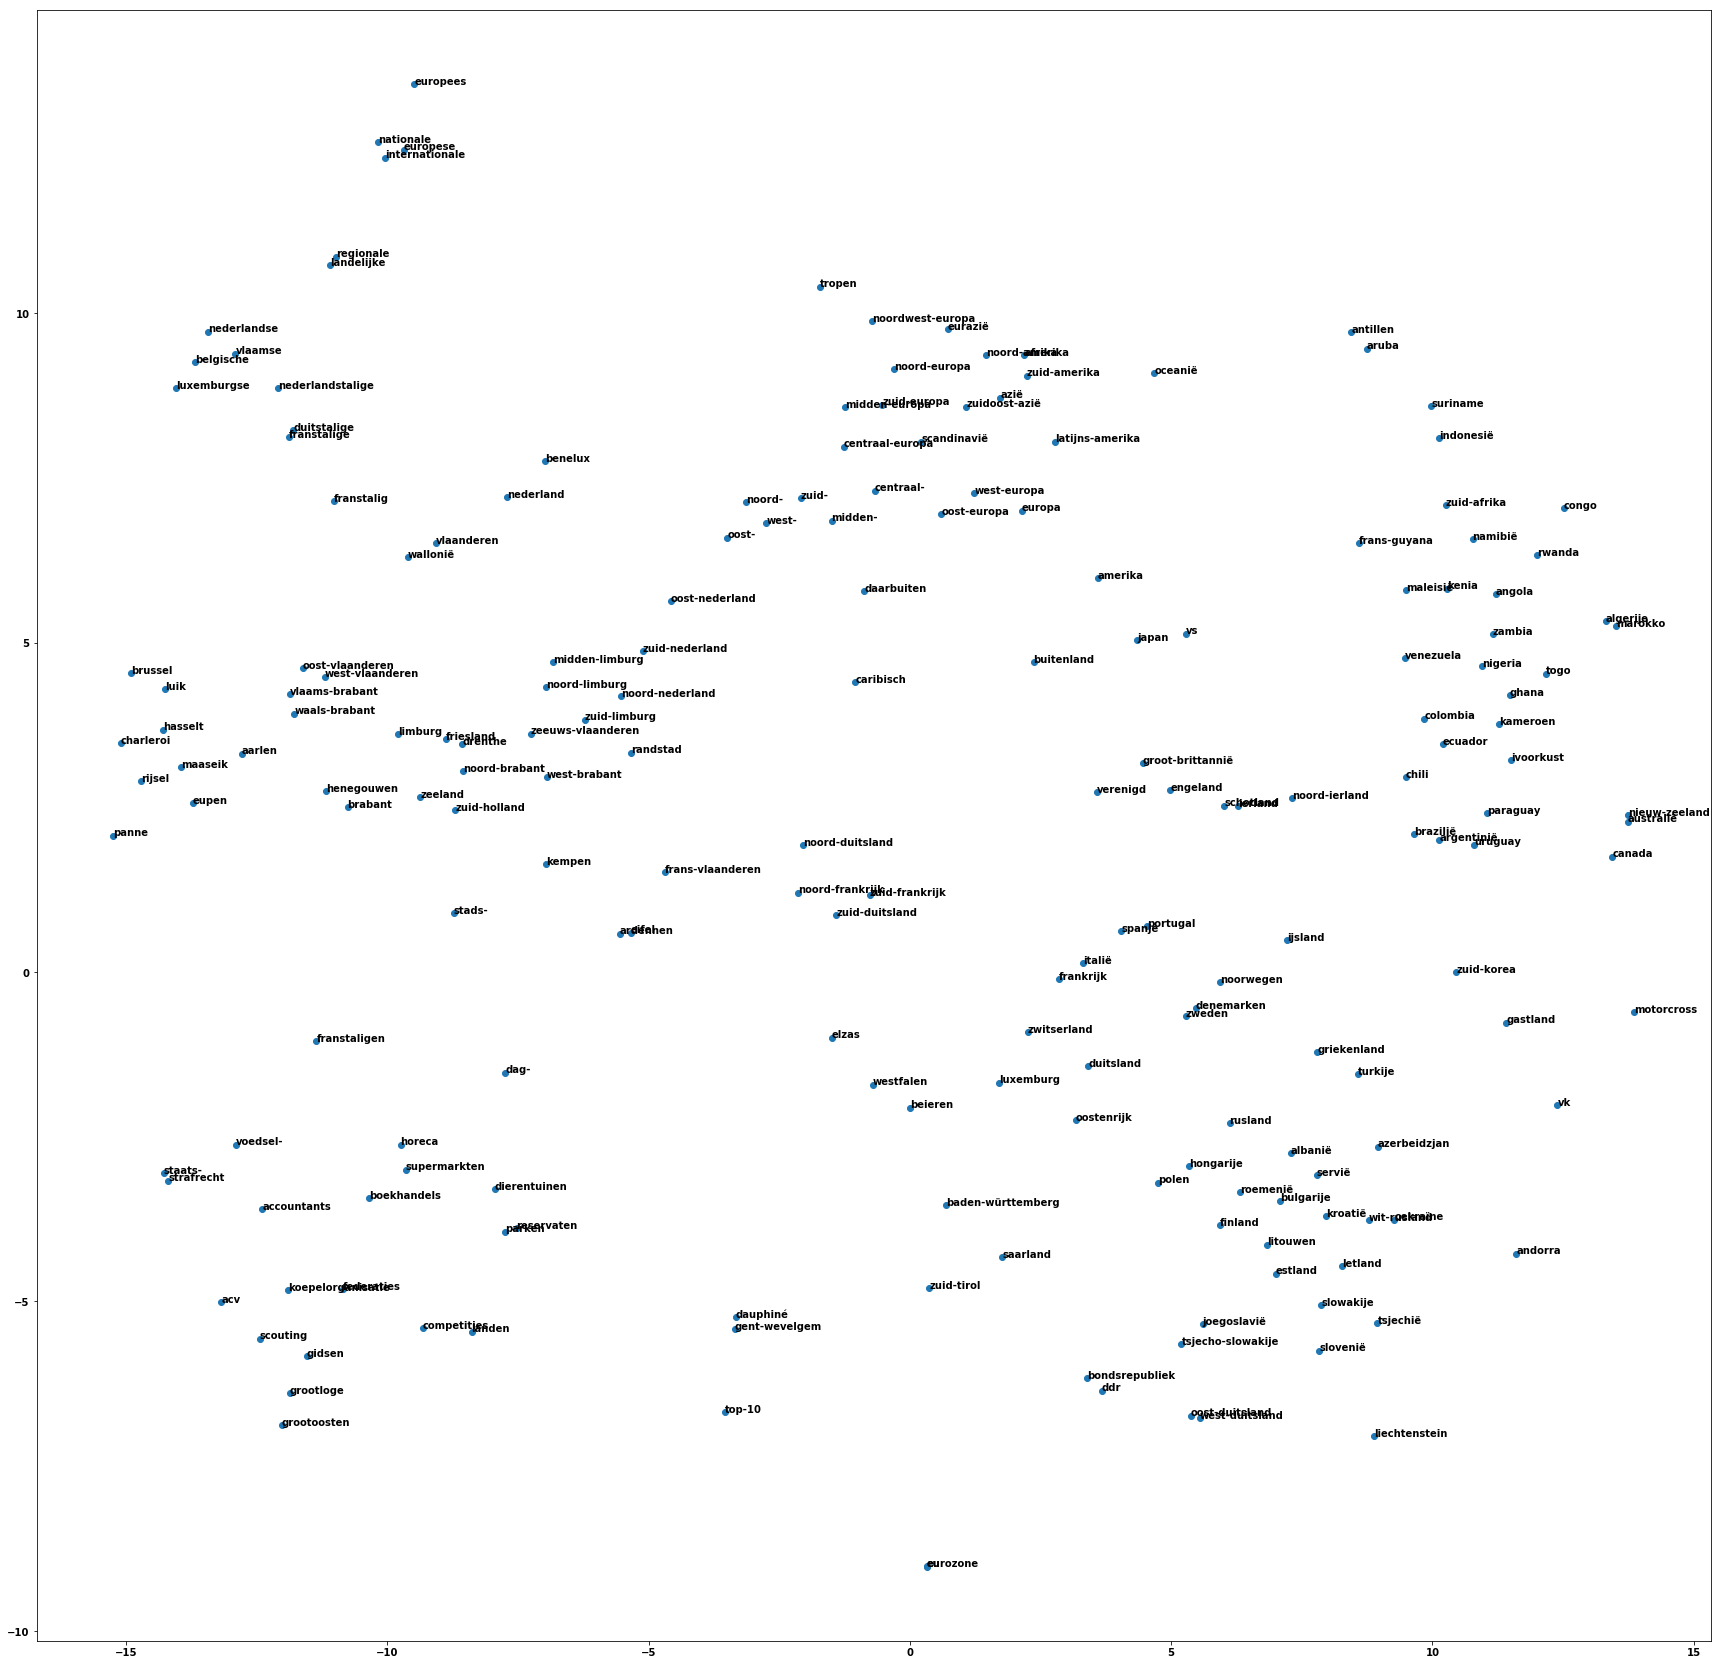

In [39]:
plt.figure(figsize=(30,30))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(selected_words):
    plt.annotate(txt, (x[i], y[i]))

## Exploring hyperparameters

We mentioned above there are a number of parameters when can set when training our embeddings. Let's investigate the impact some of these have on the result. Quantifying the quality of embeddings is a hard task. There exist quite a few data sets for [evaluating the quality of English embeddings](https://github.com/kudkudak/word-embeddings-benchmarks), but this is not the case for other languages. Moreover, it's unclear what information good embeddings should capture. Should they model syntactic information as well as semantic knowledge? Should they capture semantic similarity, or merely topical relatedness? Often, the answer depends on the end task you want to use the embeddings for. 

Here we'll use a simple method for evaluating our embeddings. We'll count how many times two nearest neighbours in the vector space have the same part of speech. After all, if our embeddings are any good, we expect a noun to have another noun as nearest neighbour, and the same for verbs, adjectives, and so on.

First we'll use [spaCy](https://spacy.io/) to determine the part of speech of all the words in our vocabulary. Note that our evaluation metric does rely on the quality of spaCy's part-of-speech tagging, which may not be very accurate for low-frequency words out of context. Nevertheless, we'll assume it's good enough for our purposes. 

In [40]:
import spacy
from tqdm import tqdm_notebook as tqdm

nl = spacy.load("nl")

word2pos = {}
for word in tqdm(model.wv.vocab):
    word2pos[word] = nl(word)[0].pos_

word2pos["koning"]

'NOUN'

Then we write a simple method that takes a model and looks up the nearest neighbour to every word in its vocabulary. It then returns the number of times this nearest neighbour has the same part of speech: a percentage we'll call the accuracy.

In [17]:
import numpy as np

def evaluate(model, word2pos):
    same = 0
    for word in tqdm(model.wv.vocab):
        most_similar = model.wv.similar_by_word(word, topn=1)[0][0]
        if word2pos[most_similar] == word2pos[word]:
            same += 1
    return same/len(model.wv.vocab)
       
evaluate(model, word2pos)

0.6395543481243654

Now we vary some of the settings we introduced above. In particular we're interested in the influence of embedding size (the dimensionality of the trained embeddings), and the size of the context window. We vary the embedding size between 100, 200 and 300,and the context window between 2, 5 and 10. This means we'll train 9 models in total, which obviously takes a bit of time. Go grab a coffee. Or two. 

In [19]:
sizes = [100, 200, 300]
windows = [2,5,10]

df = pd.DataFrame(index=windows, columns=sizes)

for size in sizes:
    for window in windows:
        print("Size:", size, "Window:", window)
        model = gensim.models.Word2Vec(sentences, min_count=100, window=window, size=size)
        acc = evaluate(model, word2pos)
        df[size][window] = acc
        
df

Size: 100 Window: 2



Size: 100 Window: 5



Size: 100 Window: 10



Size: 200 Window: 2



Size: 200 Window: 5



Size: 200 Window: 10



Size: 300 Window: 2



Size: 300 Window: 5



Size: 300 Window: 10


,100,200,300
2,0.64164,0.643616,0.639609
5,0.636618,0.63681,0.637716
10,0.633188,0.636261,0.633929


Although the accuracies of all models are very similar, the results do show some interesting patterns. 

First, it looks like smaller contexts work better than larger ones. This is logical, as our evaluation metric is a syntactic one: the closest context words contain much more useful information about the part of speech of a word than those further away. 

Second, 200-dimensional context embeddings seem to work best. This may sound counter-intuitive, as higher-dimensional embeddings are able to capture more information. Still, such higher-dimensional embeddings also require more data. For the relatively small corpus we're working with, 200-dimensional embeddings strik the perfect balance.

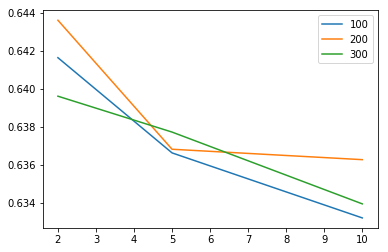

In [21]:
df.plot()

## Clustering embeddings

Finally, we're going to cluster our embeddings. This will be useful for our experiments with Named Entity Recognition later, where embedding clusters allow Conditional Random Fields to model semantic information. We'll use agglomerative clustering, a bottom-up clustering method that iteratively takes together the two most similar clusters (or embeddings) in the data.

In [42]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

vocab = list(model.wv.vocab)
vectors = [model.wv[w] for w in vocab]
vectors_norm = normalize(vectors)

clusterer = AgglomerativeClustering(n_clusters=500)
clusters = clusterer.fit_predict(vectors_norm)


Let's inspect some of the clusters. By focusing some of the clusters that contain the names of countries, we can see how these clusters can be useful for Named Entity Recognition. When a CRF encounters a word it has never seen, it can rely on the fact that it is present in a country cluster, to label it as a location. The same goes for other entity types. We'll save the clusters to a file so we can use them later.

In [43]:
cluster_dictionary = {}
for cluster, word in zip(clusters, vocab): 
    if cluster not in cluster_dictionary:
        cluster_dictionary[cluster] = []
    cluster_dictionary[cluster].append(word)

In [45]:
for x in cluster_dictionary:
    if "italië" in cluster_dictionary[x]:
        print(cluster_dictionary[x])

['duitsland', 'frankrijk', 'oostenrijk', 'italië', 'zwitserland', 'slovenië', 'liechtenstein', 'joegoslavië', 'spanje', 'polen', 'turkije', 'luxemburg', 'macedonië', 'sovjet-unie', 'rusland', 'ussr', 'griekenland', 'portugal', 'tsjecho-slowakije', 'tsjechië', 'hongarije', 'tsjechoslowakije', 'roemenië', 'bulgarije', 'denemarken', 'noorwegen', 'zweden', 'finland', 'oekraïne', 'oost-duitsland', 'bondsrepubliek', 'servië', 'west-duitsland', 'armenië', 'bosnië', 'cyprus', 'wit-rusland', 'litouwen', 'letland', 'albanië', 'slowakije', 'ddr', 'georgië', 'oost-berlijn', 'west-berlijn', 'estland', 'montenegro', 'kroatië', 'herzegovina', 'vojvodina']


In [13]:
with open("data/clusters_nl.tsv", "w") as o:
    for c in cluster_dictionary:
        for w in cluster_dictionary[c]:
            o.write(f"{w}\t{c}\n")

## Conclusions

Word embeddings are one of the most exciting trends on Natural Language Processing since the 2000s. They allow us to model the meaning and usage of a word, and discover words that behave similarly. This is crucial for the generalization capacity of many machine learning models. Moving from raw strings to embeddings allows them to generalize across words that have a similar meaning, and discover patterns that had previously escaped them.